## Librerias

In [154]:
# 1. Importación de Librerías
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos

In [155]:
df = pd.read_csv(r'C:\Users\zamli\OneDrive\Escritorio\proyectos\music-genre-classification\data\raw\features_30_sec.csv')

# 3. Visualización Inicial de Datos
print(f"Primeras filas del dataset:")
df.head()

Primeras filas del dataset:


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [156]:
print(f"Resumen estadístico del dataset:\n{df.describe()}")

Resumen estadístico del dataset:
              length  chroma_stft_mean  chroma_stft_var     rms_mean  \
count    1000.000000       1000.000000      1000.000000  1000.000000   
mean   662030.846000          0.378682         0.086340     0.130930   
std      1784.073992          0.081705         0.007735     0.065683   
min    660000.000000          0.171939         0.044555     0.005276   
25%    661504.000000          0.319562         0.082298     0.086657   
50%    661794.000000          0.383148         0.086615     0.122443   
75%    661794.000000          0.435942         0.091256     0.175682   
max    675808.000000          0.663685         0.108111     0.397973   

           rms_var  spectral_centroid_mean  spectral_centroid_var  \
count  1000.000000             1000.000000           1.000000e+03   
mean      0.003051             2201.780898           4.696916e+05   
std       0.003634              715.960600           4.008995e+05   
min       0.000004              570.040355

## 4. Correlaciones (para entender la relación entre las características)


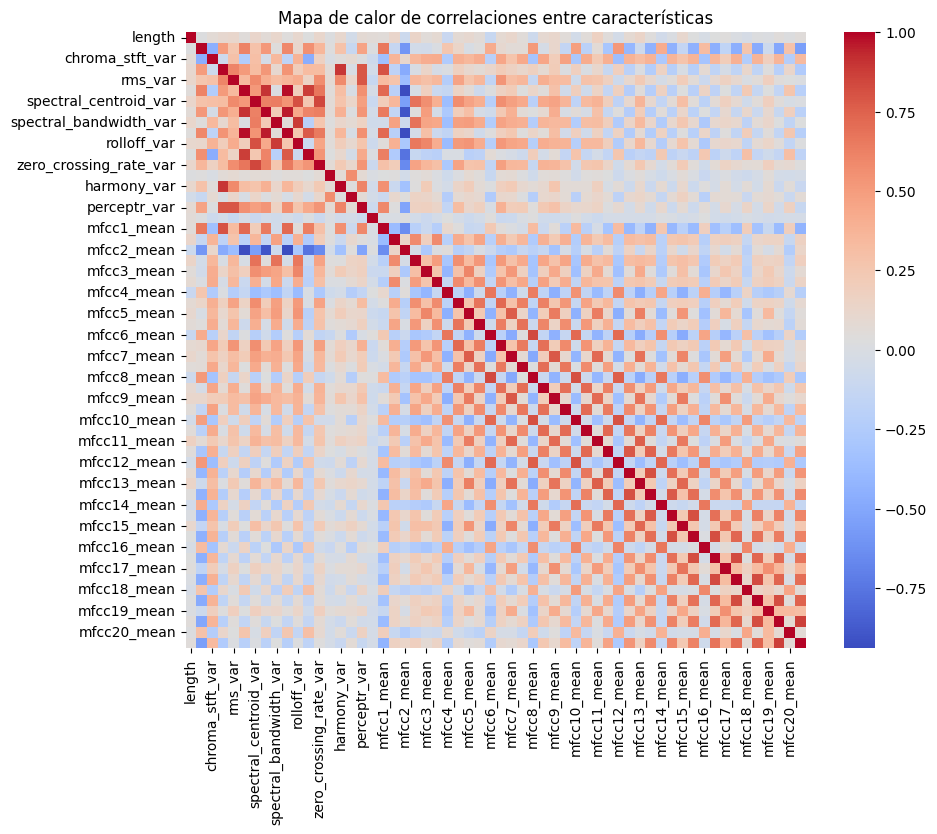

In [158]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(columns=['filename', 'label']).corr(), cmap='coolwarm', annot=False)
plt.title('Mapa de calor de correlaciones entre características')
plt.show()


## 5. Preprocesamiento


In [159]:
# Separar características (X) y variable objetivo (y)
X = df.drop(columns=['filename', 'label'])
y = df[['label']]

In [160]:
# Aplicar One-Hot Encoding a la variable objetivo (label)
ohe = OneHotEncoder(sparse_output=False)
y_ohe = ohe.fit_transform(y)

In [161]:
# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 6. División de Datos en Conjuntos de Entrenamiento y Prueba


In [162]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_ohe, test_size=0.2, random_state=42)

## 7. Conversión de los Datos a Tensores


In [163]:
# 7. Conversión de los Datos a Tensores
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

## 8. Definición del Modelo de Red Neuronal


In [131]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(in_features=58, out_features=128)
        self.hidden_layer = nn.Linear(in_features=128, out_features=64)
        self.output_layer = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        Y0 = F.tanh(self.input_layer(x))
        Y1 = F.tanh(self.hidden_layer(Y0))
        Y2 = self.output_layer(Y1)
        return Y2

## 9. Inicialización del Modelo, Función de Pérdida y Optimizador


In [134]:
model = NN()
loss_fn = nn.CrossEntropyLoss()  # Usando CrossEntropy como función de pérdida
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

## 10. Entrenamiento del Modelo


In [135]:
epochs = 500
loss_train_history = []
loss_test_history = []
accuracy_train_history = []
accuracy_test_history = []

for epoch in range(epochs):
    # Training
    model.train()
    
    # Forward pass en entrenamiento
    y_pred = model(X_train)
    
    # Convert logits to class predictions
    y_pred_labels = torch.argmax(y_pred, dim=1)
    
    # Loss and Accuracy
    loss = loss_fn(y_pred, torch.argmax(y_train, dim=1))
    accuracy = accuracy_score(torch.argmax(y_train, dim=1).numpy(), y_pred_labels.numpy())
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Guardar las pérdidas y la precisión en el entrenamiento
    loss_train_history.append(loss.item())
    accuracy_train_history.append(accuracy)
    
    # Testing
    model.eval()
    with torch.inference_mode():
        # Forward pass en prueba
        y_test_pred = model(X_test)
        
        # Convert logits to class predictions
        y_test_pred_labels = torch.argmax(y_test_pred, dim=1)
        
        # Loss y precisión en prueba
        test_loss = loss_fn(y_test_pred, torch.argmax(y_test, dim=1))
        test_accuracy = accuracy_score(torch.argmax(y_test, dim=1).numpy(), y_test_pred_labels.numpy())

        # Guardar las pérdidas y la precisión en la prueba
        loss_test_history.append(test_loss.item())
        accuracy_test_history.append(test_accuracy)
    
    # Imprimir progreso cada 50 épocas
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] => "
              f"Train Loss: {loss:.4f}, Train Accuracy: {accuracy * 100:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch [50/500] => Train Loss: 1.3522, Train Accuracy: 51.25%, Test Loss: 1.5390, Test Accuracy: 41.00%
Epoch [100/500] => Train Loss: 1.0512, Train Accuracy: 65.25%, Test Loss: 1.2931, Test Accuracy: 50.50%
Epoch [150/500] => Train Loss: 0.8489, Train Accuracy: 74.62%, Test Loss: 1.1363, Test Accuracy: 59.50%
Epoch [200/500] => Train Loss: 0.7056, Train Accuracy: 80.88%, Test Loss: 1.0294, Test Accuracy: 64.50%
Epoch [250/500] => Train Loss: 0.6008, Train Accuracy: 83.38%, Test Loss: 0.9602, Test Accuracy: 66.50%
Epoch [300/500] => Train Loss: 0.5216, Train Accuracy: 85.50%, Test Loss: 0.9173, Test Accuracy: 69.50%
Epoch [350/500] => Train Loss: 0.4594, Train Accuracy: 88.12%, Test Loss: 0.8928, Test Accuracy: 69.50%
Epoch [400/500] => Train Loss: 0.4085, Train Accuracy: 89.75%, Test Loss: 0.8808, Test Accuracy: 71.00%
Epoch [450/500] => Train Loss: 0.3656, Train Accuracy: 90.75%, Test Loss: 0.8770, Test Accuracy: 71.50%
Epoch [500/500] => Train Loss: 0.3285, Train Accuracy: 91.50%, Te

## 11. Graficar la Pérdida y la Precisión durante el Entrenamiento y la Prueba

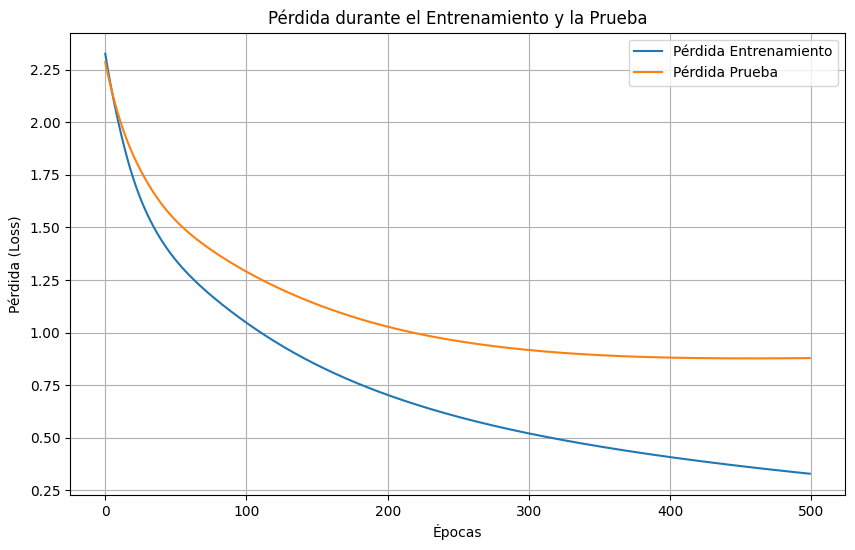

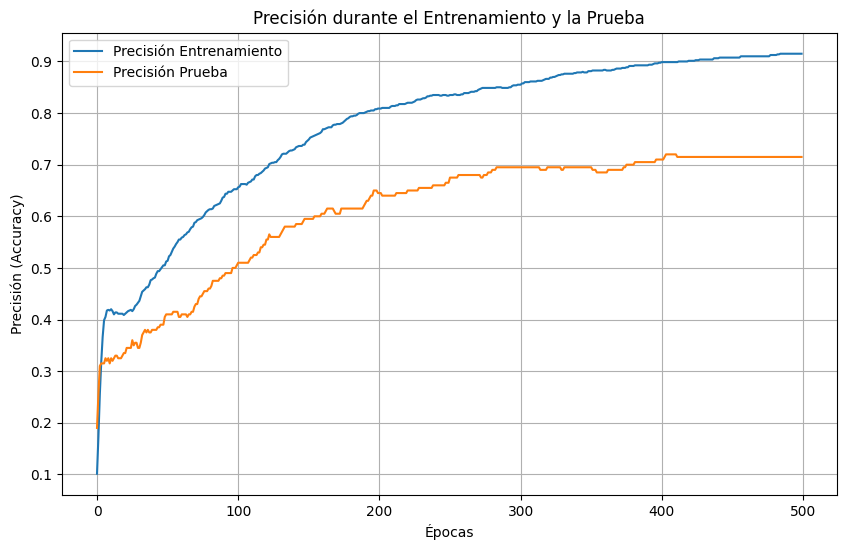

In [137]:
plt.figure(figsize=(10, 6))
plt.plot(loss_train_history, label='Pérdida Entrenamiento')
plt.plot(loss_test_history, label='Pérdida Prueba')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.title('Pérdida durante el Entrenamiento y la Prueba')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(accuracy_train_history, label='Precisión Entrenamiento')
plt.plot(accuracy_test_history, label='Precisión Prueba')
plt.xlabel('Épocas')
plt.ylabel('Precisión (Accuracy)')
plt.title('Precisión durante el Entrenamiento y la Prueba')
plt.legend()
plt.grid(True)
plt.show()

## 12. Evaluación Final


In [138]:
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred_labels = torch.argmax(y_test_pred, dim=1)
    y_test_true = torch.argmax(y_test, dim=1)

## 13. Reporte de Clasificación


In [139]:
y_test_pred_labels_np = y_test_pred_labels.numpy()
y_test_true_np = y_test_true.numpy()

In [142]:
# Mostrar el reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test_true_np, y_test_pred_labels_np))

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        20
           1       0.86      0.92      0.89        13
           2       0.76      0.70      0.73        27
           3       0.60      0.43      0.50        21
           4       0.60      0.80      0.69        15
           5       0.90      0.86      0.88        22
           6       0.88      0.92      0.90        25
           7       0.69      0.85      0.76        13
           8       0.65      0.48      0.55        23
           9       0.54      0.62      0.58        21

    accuracy                           0.71       200
   macro avg       0.71      0.73      0.71       200
weighted avg       0.72      0.71      0.71       200



## 14. Matriz de Confusión


In [143]:
cm = confusion_matrix(y_test_true_np, y_test_pred_labels_np)

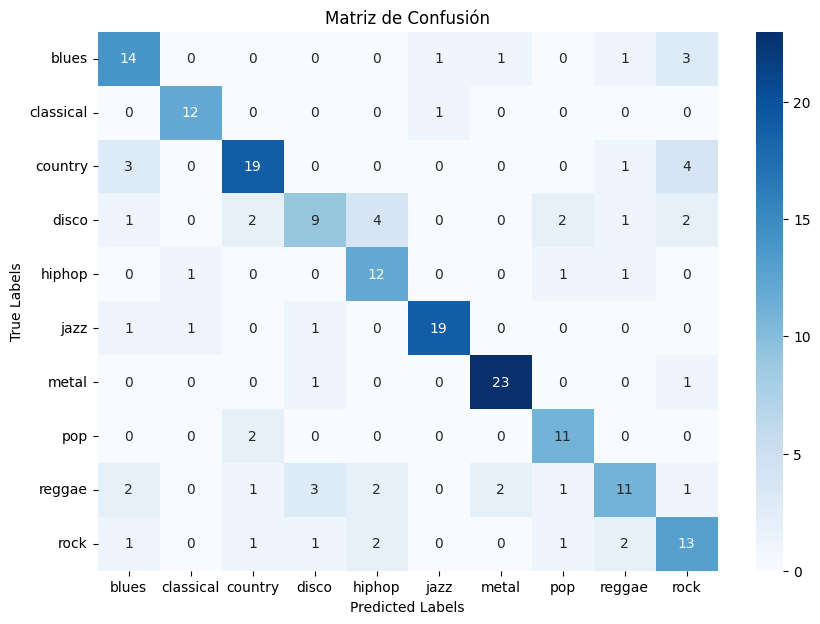

In [144]:
# 15. Graficar la Matriz de Confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ohe.categories_[0], yticklabels=ohe.categories_[0])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matriz de Confusión')
plt.show()

# Bonus Track MSE

## 2. Modificación del Modelo para Usar MSE



In [145]:
# 2. Modificación del Modelo para Usar MSE
class NN_MSE(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(in_features=58, out_features=128)
        self.hidden_layer = nn.Linear(in_features=128, out_features=64)
        self.output_layer = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        # Activación tanh en las capas ocultas
        Y0 = F.tanh(self.input_layer(x))  # Capa de entrada seguida de activación Tanh
        Y1 = F.tanh(self.hidden_layer(Y0))  # Capa oculta seguida de activación Tanh
        Y2 = torch.sigmoid(self.output_layer(Y1))  # Capa de salida seguida de Sigmoid
        return Y2

## 3. Entrenamiento con MSE


In [148]:
# 3. Entrenamiento con MSE
model_mse = NN_MSE()
loss_fn_mse = nn.MSELoss()  # Usando MSE como función de pérdida
optimizer_mse = torch.optim.SGD(model_mse.parameters(), lr=0.1)

# Inicializar listas para almacenar las pérdidas y precisiones durante el entrenamiento
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

# Entrenamiento con MSE (o CrossEntropy)
epochs = 500

for epoch in range(epochs):
    # Training
    model_mse.train()
    
    # Forward pass en entrenamiento
    y_pred = model_mse(X_train)
    
    # Convert logits to class predictions
    y_pred_labels = torch.argmax(y_pred, dim=1)
    
    # Loss y Accuracy
    loss = loss_fn_mse(y_pred, y_train)
    accuracy = accuracy_score(torch.argmax(y_train, dim=1).numpy(), y_pred_labels.numpy())
    
    # Backpropagation
    optimizer_mse.zero_grad()
    loss.backward()
    optimizer_mse.step()
    
    # Guardar métricas de entrenamiento
    train_loss_history.append(loss.item())
    train_accuracy_history.append(accuracy)
    
    # Testing
    model_mse.eval()
    with torch.inference_mode():
        y_test_pred = model_mse(X_test)
        y_test_pred_labels = torch.argmax(y_test_pred, dim=1)
        test_loss = loss_fn_mse(y_test_pred, y_test)
        test_accuracy = accuracy_score(torch.argmax(y_test, dim=1).numpy(), y_test_pred_labels.numpy())
    
    # Guardar métricas de prueba
    test_loss_history.append(test_loss.item())
    test_accuracy_history.append(test_accuracy)
    
    # Imprimir resultados cada 50 épocas
    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{epochs}] => Loss: {loss:.4f}, Accuracy: {accuracy * 100:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch [0/500] => Loss: 0.2442, Accuracy: 8.00%, Test Loss: 0.2453, Test Accuracy: 7.00%
Epoch [50/500] => Loss: 0.2069, Accuracy: 22.75%, Test Loss: 0.2090, Test Accuracy: 18.00%
Epoch [100/500] => Loss: 0.1729, Accuracy: 36.12%, Test Loss: 0.1758, Test Accuracy: 28.00%
Epoch [150/500] => Loss: 0.1427, Accuracy: 42.12%, Test Loss: 0.1461, Test Accuracy: 30.50%
Epoch [200/500] => Loss: 0.1192, Accuracy: 44.50%, Test Loss: 0.1228, Test Accuracy: 33.50%
Epoch [250/500] => Loss: 0.1036, Accuracy: 44.75%, Test Loss: 0.1071, Test Accuracy: 33.50%
Epoch [300/500] => Loss: 0.0941, Accuracy: 45.12%, Test Loss: 0.0975, Test Accuracy: 34.00%
Epoch [350/500] => Loss: 0.0883, Accuracy: 44.38%, Test Loss: 0.0917, Test Accuracy: 33.50%
Epoch [400/500] => Loss: 0.0846, Accuracy: 42.75%, Test Loss: 0.0881, Test Accuracy: 32.50%
Epoch [450/500] => Loss: 0.0821, Accuracy: 41.88%, Test Loss: 0.0856, Test Accuracy: 33.00%


## Entrenamiento

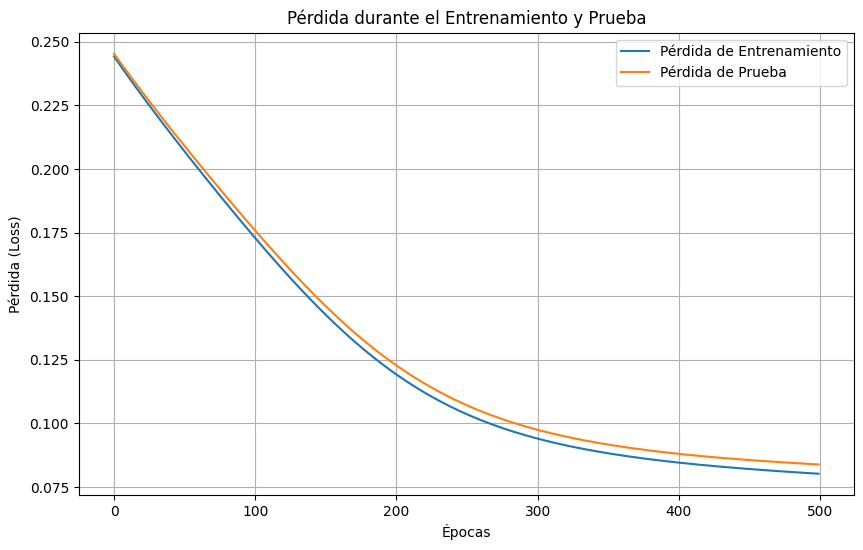

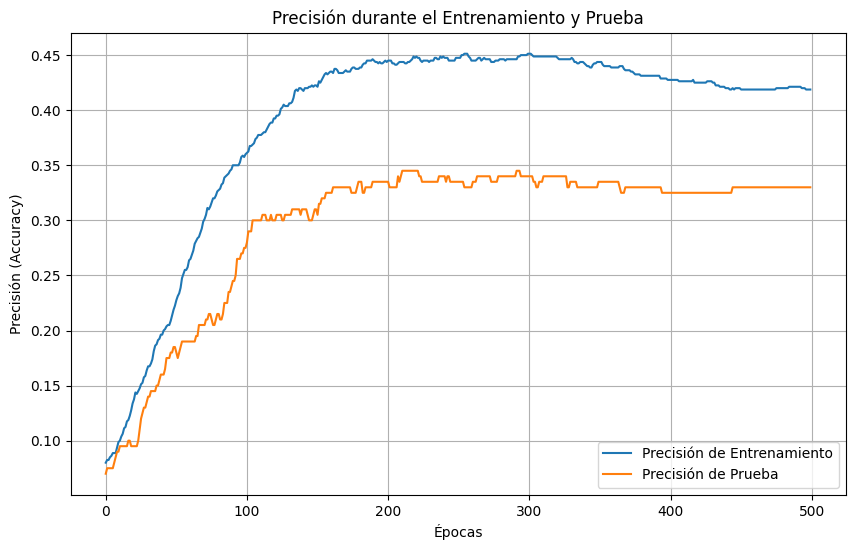

In [150]:
# Gráfica de las pérdidas
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Pérdida de Entrenamiento')
plt.plot(test_loss_history, label='Pérdida de Prueba')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.title('Pérdida durante el Entrenamiento y Prueba')
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de las precisiones
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy_history, label='Precisión de Entrenamiento')
plt.plot(test_accuracy_history, label='Precisión de Prueba')
plt.xlabel('Épocas')
plt.ylabel('Precisión (Accuracy)')
plt.title('Precisión durante el Entrenamiento y Prueba')
plt.legend()
plt.grid(True)
plt.show()